In [7]:
import os
import pickle

In [8]:
#change working directory
os.chdir('/work/postresearch/Shared/Researchers/Farbod/cancer')

# Create data

INFO:Simulating initial volumes for stage I  with norm params: mu=1.72, sigma=4.7, lb=-0.6221218732608375, ub=-0.023523848418276528
INFO:Simulating initial volumes for stage II  with norm params: mu=1.96, sigma=1.63, lb=-1.9410876100159118, ub=0.3711345751297772
INFO:Simulating initial volumes for stage IIIA  with norm params: mu=1.91, sigma=9.4, lb=-0.33127370258786554, ub=0.06967546355973796
INFO:Simulating initial volumes for stage IIIB  with norm params: mu=2.76, sigma=6.87, lb=-0.5769974969906748, ub=-0.02839165102452155
INFO:Simulating initial volumes for stage IV  with norm params: mu=3.86, sigma=8.82, lb=-0.5741465764541878, ub=-0.14683113860980307


INFO:Got correlated params for 4597 patients
INFO:Got correlated params for 9177 patients
INFO:Got correlated params for 13793 patients
INFO:Simulating beta_c parameters
INFO:Randomising outputs
  0%|          | 0/10000 [00:00<?, ?it/s]/tmp/ipykernel_29498/1147257597.py:346: RuntimeWarning: overflow encountered in exp
  if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
100%|██████████| 10000/10000 [00:16<00:00, 607.35it/s]
INFO:Simulating initial volumes for stage I  with norm params: mu=1.72, sigma=4.7, lb=-0.6221218732608375, ub=-0.023523848418276528
INFO:Simulating initial volumes for stage II  with norm params: mu=1.96, sigma=1.63, lb=-1.9410876100159118, ub=0.3711345751297772
INFO:Simulating initial volumes for stage IIIA  with norm params: mu=1.91, sigma=9.4, lb=-0.33127370258786554, ub=0.06967546355973796
INFO:Simulating initial volumes for stage IIIB  with norm params: mu=2.76, sigma=6.87, lb=-0.5769974969906748, ub=-0.02839165102452155
INFO:Simulating

Call to simulate counterfactuals data


  8%|▊         | 79/1000 [00:02<00:27, 33.71it/s]/tmp/ipykernel_29498/1147257597.py:734: RuntimeWarning: invalid value encountered in log
  (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
100%|██████████| 1000/1000 [00:27<00:00, 36.69it/s]


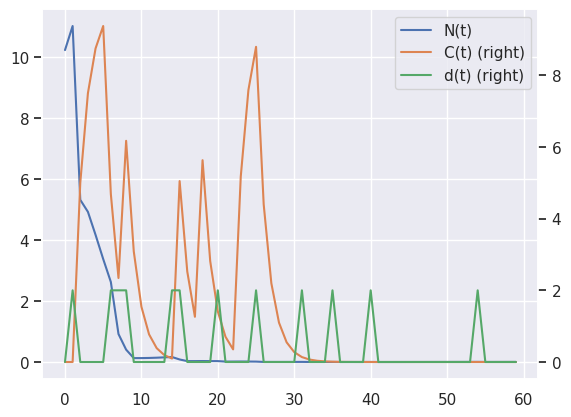

In [3]:
# -*- coding: utf-8 -*-
"""
[Treatment Effects with RNNs] cancer_simulation
Created on 2/4/2018 8:14 AM

Medically realistic data simulation for small-cell lung cancer based on Geng et al 2017.
URL: https://www.nature.com/articles/s41598-017-13646-z

Notes:
- Simulation time taken to be in days

@author: limsi
"""

import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.stats import truncnorm  # we need to sample from truncated normal distributions

sns.set()


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Constants

# Spherical calculations - tumours assumed to be spherical per Winer-Muram et al 2002.
# URL:
# https://pubs.rsna.org/doi/10.1148/radiol.2233011026?url_ver=Z39.88-2003&rfr_id=ori%3Arid%3Acrossref.org&rfr_dat=cr_pub%3Dpubmed


def calc_volume(diameter):
    return 4 / 3 * np.pi * (diameter / 2) ** 3


def calc_diameter(volume):
    return ((volume / (4 / 3 * np.pi)) ** (1 / 3)) * 2


# Tumour constants per
TUMOUR_CELL_DENSITY = 5.8 * 10 ** 8  # cells per cm^3
TUMOUR_DEATH_THRESHOLD = calc_volume(13)  # assume spherical

# Patient cancer stage. (mu, sigma, lower bound, upper bound) - for lognormal dist
tumour_size_distributions = {'I': (1.72, 4.70, 0.3, 5.0),
                             'II': (1.96, 1.63, 0.3, 13.0),
                             'IIIA': (1.91, 9.40, 0.3, 13.0),
                             'IIIB': (2.76, 6.87, 0.3, 13.0),
                             'IV': (3.86, 8.82, 0.3, 13.0)}  # 13.0 is the death condition

# Observations of stage proportions taken from Detterbeck and Gibson 2008
# - URL: http://www.jto.org/article/S1556-0864(15)33353-0/fulltext#cesec50\
cancer_stage_observations = {'I': 1432,
                             "II": 128,
                             "IIIA": 1306,
                             "IIIB": 7248,
                             "IV": 12840}


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Simulation Functions


def generate_params(num_patients, chemo_coeff, radio_coeff, lag, window_size = 15):
    """
    Get original patient-specific simulation parameters, and add extra ones to control confounding

    :param num_patients: Number of patients to simulate
    :param chemo_coeff: Bias on action policy for chemotherapy assignments
    :param radio_activation_group: Bias on action policy for chemotherapy assignments
    :return: dict of parameters
    """

    basic_params = get_standard_params(num_patients)
    patient_types = basic_params['patient_types']
    # tumour_stage_centres = [s for s in cancer_stage_observations if 'IIIA' not in s]
    # tumour_stage_centres.sort()

    # Parameters controlling sigmoid application probabilities

    D_MAX = calc_diameter(TUMOUR_DEATH_THRESHOLD)
    basic_params['chemo_sigmoid_intercepts'] = np.array([D_MAX / 2.0 for _ in patient_types])
    basic_params['radio_sigmoid_intercepts'] = np.array([D_MAX / 2.0 for _ in patient_types])

    basic_params['chemo_sigmoid_betas'] = np.array([chemo_coeff / D_MAX for _ in patient_types])
    basic_params['radio_sigmoid_betas'] = np.array([radio_coeff / D_MAX for _ in patient_types])

    basic_params['window_size'] = window_size
    basic_params['lag'] = lag

    return basic_params


def get_standard_params(num_patients):  # additional params
    """
    Simulation parameters from the Nature article + adjustments for static variables

    :param num_patients: Number of patients to simulate
    :return: simulation_parameters: Initial volumes + Static variables (e.g. response to treatment); randomly shuffled
    """

    # INITIAL VOLUMES SAMPLING
    TOTAL_OBS = sum(cancer_stage_observations.values())
    cancer_stage_proportions = {k: cancer_stage_observations[k] / TOTAL_OBS for k in cancer_stage_observations}

    # remove possible entries
    possible_stages = list(tumour_size_distributions.keys())
    possible_stages.sort()

    initial_stages = np.random.choice(possible_stages, num_patients,
                                      p=[cancer_stage_proportions[k] for k in possible_stages])

    # Get info on patient stages and initial volumes
    output_initial_diam = []
    patient_sim_stages = []
    for stg in possible_stages:
        count = np.sum((initial_stages == stg) * 1)

        mu, sigma, lower_bound, upper_bound = tumour_size_distributions[stg]

        # Convert lognorm bounds in to standard normal bounds
        lower_bound = (np.log(lower_bound) - mu) / sigma
        upper_bound = (np.log(upper_bound) - mu) / sigma

        logging.info(("Simulating initial volumes for stage {} " +
                      " with norm params: mu={}, sigma={}, lb={}, ub={}").format(
            stg,
            mu,
            sigma,
            lower_bound,
            upper_bound))

        norm_rvs = truncnorm.rvs(lower_bound, upper_bound,
                                 size=count)  # truncated normal for realistic clinical outcome

        initial_volume_by_stage = np.exp((norm_rvs * sigma) + mu)
        output_initial_diam += list(initial_volume_by_stage)
        patient_sim_stages += [stg for i in range(count)]

    # STATIC VARIABLES SAMPLING
    # Fixed params
    K = calc_volume(30)  # carrying capacity given in cm, so convert to volume
    ALPHA_BETA_RATIO = 10
    ALPHA_RHO_CORR = 0.87

    # Distributional parameters for dynamics
    parameter_lower_bound = 0.0
    parameter_upper_bound = np.inf
    rho_params = (7 * 10 ** -5, 7.23 * 10 ** -3)
    alpha_params = (0.0398, 0.168)
    beta_c_params = (0.028, 0.0007)

    # Get correlated simulation paramters (alpha, beta, rho) which respects bounds
    alpha_rho_cov = np.array([[alpha_params[1] ** 2, ALPHA_RHO_CORR * alpha_params[1] * rho_params[1]],
                              [ALPHA_RHO_CORR * alpha_params[1] * rho_params[1], rho_params[1] ** 2]])

    alpha_rho_mean = np.array([alpha_params[0], rho_params[0]])

    simulated_params = []

    while len(simulated_params) < num_patients:  # Keep on simulating till we get the right number of params

        param_holder = np.random.multivariate_normal(alpha_rho_mean, alpha_rho_cov, size=num_patients)

        for i in range(param_holder.shape[0]):

            # Ensure that all params fulfill conditions
            if param_holder[i, 0] > parameter_lower_bound and param_holder[i, 1] > parameter_lower_bound:
                simulated_params.append(param_holder[i, :])

        logging.info("Got correlated params for {} patients".format(len(simulated_params)))

    # Adjustments for static variables
    possible_patient_types = [1, 2, 3]
    patient_types = np.random.choice(possible_patient_types, num_patients)
    chemo_mean_adjustments = np.array([0.0 if i < 3 else 0.1 for i in patient_types])
    radio_mean_adjustments = np.array([0.0 if i > 1 else 0.1 for i in patient_types])

    simulated_params = np.array(simulated_params)[:num_patients, :]  # shorten this back to normal
    alpha_adjustments = alpha_params[0] * radio_mean_adjustments
    alpha = simulated_params[:, 0] + alpha_adjustments
    rho = simulated_params[:, 1]
    beta = alpha / ALPHA_BETA_RATIO

    # Get the remaining indep params
    logging.info("Simulating beta_c parameters")
    beta_c_adjustments = beta_c_params[0] * chemo_mean_adjustments
    beta_c = beta_c_params[0] + beta_c_params[1] * truncnorm.rvs(
        (parameter_lower_bound - beta_c_params[0]) / beta_c_params[1],
        (parameter_upper_bound - beta_c_params[0]) / beta_c_params[1],
        size=num_patients) + beta_c_adjustments

    output_holder = {'patient_types': patient_types,
                     'initial_stages': np.array(patient_sim_stages),
                     'initial_volumes': calc_volume(np.array(output_initial_diam)),  # assumed spherical with diam
                     'alpha': alpha,
                     'rho': rho,
                     'beta': beta,
                     'beta_c': beta_c,
                     'K': np.array([K for _ in range(num_patients)]),
                     }
    # np.random.exponential(expected_treatment_delay, num_patients),

    # Randomise output params
    logging.info("Randomising outputs")
    idx = [i for i in range(num_patients)]
    np.random.shuffle(idx)

    output_params = {}
    for k in output_holder:
        output_params[k] = output_holder[k][idx]

    return output_params


def simulate_factual(simulation_params, seq_length, assigned_actions=None):
    """
    Simulation of factual patient trajectories (for train and validation subset)

    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length
    :param assigned_actions: Fixed non-random treatment assignment policy, if None - standard biased random assignment is applied
    :return: simulated data dict
    """

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    # Commence Simulation
    cancer_volume = np.zeros((num_patients, seq_length))
    chemo_dosage = np.zeros((num_patients, seq_length))
    radio_dosage = np.zeros((num_patients, seq_length))
    chemo_application_point = np.zeros((num_patients, seq_length))
    radio_application_point = np.zeros((num_patients, seq_length))
    sequence_lengths = np.zeros(num_patients)
    death_flags = np.zeros((num_patients, seq_length))
    recovery_flags = np.zeros((num_patients, seq_length))
    chemo_probabilities = np.zeros((num_patients, seq_length))
    radio_probabilities = np.zeros((num_patients, seq_length))

    noise_terms = 0.01 * np.random.randn(num_patients, seq_length)  # 5% cell variability
    recovery_rvs = np.random.rand(num_patients, seq_length)

    chemo_application_rvs = np.random.rand(num_patients, seq_length)
    radio_application_rvs = np.random.rand(num_patients, seq_length)

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # logging.info("Simulating patient {} of {}".format(i + 1, num_patients))
        noise = noise_terms[i]

        # initial values
        cancer_volume[i, 0] = initial_volumes[i]
        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        # Setup cell volume
        b_death = False
        b_recover = False
        for t in range(1, seq_length):

            cancer_volume[i, t] = cancer_volume[i, t - 1] *\
                (1 + rho * np.log(K / cancer_volume[i, t - 1]) - beta_c * chemo_dosage[i, t - 1] -
                    (alpha * radio_dosage[i, t - 1] + beta * radio_dosage[i, t - 1] ** 2) + noise[t])

            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else chemo_dosage[i, t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag, 0)]
            else:
                cancer_volume_used = np.zeros((1, ))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            if assigned_actions is not None:
                chemo_prob = assigned_actions[i, t, 0]
                radio_prob = assigned_actions[i, t, 1]
            else:

                radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
                chemo_prob = (1.0 / (1.0 + np.exp(-chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))
            chemo_probabilities[i, t] = chemo_prob
            radio_probabilities[i, t] = radio_prob

            # Action application
            if radio_application_rvs[i, t] < radio_prob:
                radio_application_point[i, t] = 1
                radio_dosage[i, t] = radio_amt[0]

            if chemo_application_rvs[i, t] < chemo_prob:
                # Apply chemo treatment
                chemo_application_point[i, t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            chemo_dosage[i, t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            if cancer_volume[i, t] > TUMOUR_DEATH_THRESHOLD:
                cancer_volume[i, t] = TUMOUR_DEATH_THRESHOLD
                b_death = True
                break  # patient death

            # recovery threshold as defined by the previous stuff
            if recovery_rvs[i, t] < np.exp(-cancer_volume[i, t] * TUMOUR_CELL_DENSITY):
                cancer_volume[i, t] = 0
                b_recover = True
                break

        # Package outputs
        sequence_lengths[i] = int(t)
        death_flags[i, t] = 1 if b_death else 0
        recovery_flags[i, t] = 1 if b_recover else 0

    outputs = {'cancer_volume': cancer_volume,
               'chemo_dosage': chemo_dosage,
               'radio_dosage': radio_dosage,
               'chemo_application': chemo_application_point,
               'radio_application': radio_application_point,
               'chemo_probabilities': chemo_probabilities,
               'radio_probabilities': radio_probabilities,
               'sequence_lengths': sequence_lengths,
               'death_flags': death_flags,
               'recovery_flags': recovery_flags,
               'patient_types': patient_types
               }

    return outputs


def simulate_counterfactual_1_step(simulation_params, seq_length):
    """
    Simulation of test trajectories to asses all one-step ahead counterfactuals
    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length (number of factual time-steps)
    :return: simulated data dict with number of rows equal to num_patients * seq_length * num_treatments
    """

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    num_treatments = 4  # No treatment / Chemotherapy / Radiotherapy / Chemotherapy + Radiotherapy

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = num_patients * seq_length * num_treatments

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, seq_length))
    chemo_application_point = np.zeros((num_test_points, seq_length))
    radio_application_point = np.zeros((num_test_points, seq_length))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # if i % 200 == 0:
        #     logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(seq_length)  # 5% cell variability
        recovery_rvs = np.random.rand(seq_length)

        # initial values
        factual_cancer_volume = np.zeros(seq_length)
        factual_chemo_dosage = np.zeros(seq_length)
        factual_radio_dosage = np.zeros(seq_length)
        factual_chemo_application_point = np.zeros(seq_length)
        factual_radio_application_point = np.zeros(seq_length)
        factual_chemo_probabilities = np.zeros(seq_length)
        factual_radio_probabilities = np.zeros(seq_length)

        chemo_application_rvs = np.random.rand(seq_length)
        radio_application_rvs = np.random.rand(seq_length)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, seq_length - 1):

            # Factual prev_treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag + 1, 0)]
            else:
                cancer_volume_used = np.zeros((1, ))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual prev_treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * \
                (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * factual_chemo_dosage[t] -
                    (alpha * factual_radio_dosage[t] + beta * factual_radio_dosage[t] ** 2) + noise[t + 1])

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, TUMOUR_DEATH_THRESHOLD)

            # Populate arrays
            cancer_volume[test_idx] = factual_cancer_volume
            chemo_application_point[test_idx] = factual_chemo_application_point
            radio_application_point[test_idx] = factual_radio_application_point
            patient_types_all_trajectories[test_idx] = patient_types[i]
            sequence_lengths[test_idx] = int(t) + 1
            test_idx = test_idx + 1

            # Counterfactual prev_treatments and outcomes
            treatment_options = [(0, 0), (0, 1), (1, 0), (1, 1)]  # First = chemo; second = radio

            for treatment_option in treatment_options:
                if (factual_chemo_application_point[t] == treatment_option[0] and factual_radio_application_point[t] ==
                        treatment_option[1]):
                    # This represents the factual treatment which was already considered
                    continue
                current_chemo_dose = 0.0
                counterfactual_radio_dosage = 0.0
                counterfactual_chemo_application_point = 0
                counterfactual_radio_application_point = 0

                if treatment_option[0] == 1:
                    counterfactual_chemo_application_point = 1
                    current_chemo_dose = chemo_amt[0]

                if treatment_option[1] == 1:
                    counterfactual_radio_application_point = 1
                    counterfactual_radio_dosage = radio_amt[0]

                counterfactual_chemo_dosage = previous_chemo_dose * np.exp(
                    -np.log(2) / drug_half_life) + current_chemo_dose

                counterfactual_cancer_volume = factual_cancer_volume[t] *\
                    (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * counterfactual_chemo_dosage -
                        (alpha * counterfactual_radio_dosage + beta * counterfactual_radio_dosage ** 2) + noise[t + 1])

                cancer_volume[test_idx][:t + 2] = np.append(factual_cancer_volume[:t + 1],
                                                            [counterfactual_cancer_volume])
                chemo_application_point[test_idx][:t + 1] = np.append(factual_chemo_application_point[:t],
                                                                      [counterfactual_chemo_application_point])
                radio_application_point[test_idx][:t + 1] = np.append(factual_radio_application_point[:t],
                                                                      [counterfactual_radio_application_point])
                patient_types_all_trajectories[test_idx] = patient_types[i]
                sequence_lengths[test_idx] = int(t) + 1
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= TUMOUR_DEATH_THRESHOLD) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * TUMOUR_CELL_DENSITY):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx]
               }

    print("Call to simulate counterfactuals data")

    return outputs


def simulate_counterfactuals_treatment_seq(simulation_params, seq_length, projection_horizon, cf_seq_mode='sliding_treatment'):
    """
    Simulation of test trajectories to asses a subset of multiple-step ahead counterfactuals
    :param simulation_params: Parameters of the simulation
    :param seq_length: Maximum trajectory length (number of factual time-steps)
    :param cf_seq_mode: Counterfactual sequence setting: sliding_treatment / random_trajectories
    :return: simulated data dict with number of rows equal to num_patients * seq_length * 2 * projection_horizon
    """

    if cf_seq_mode == 'sliding_treatment':
        chemo_arr = np.stack([np.eye(projection_horizon, dtype=int),
                              np.zeros((projection_horizon, projection_horizon), dtype=int)], axis=-1)
        radio_arr = np.stack([np.zeros((projection_horizon, projection_horizon), dtype=int),
                              np.eye(projection_horizon, dtype=int)], axis=-1)
        treatment_options = np.concatenate([chemo_arr, radio_arr])
    elif cf_seq_mode == 'random_trajectories':
        treatment_options = np.random.randint(0, 2, (projection_horizon * 2, projection_horizon, 2))
    else:
        raise NotImplementedError()

    total_num_radio_treatments = 1
    total_num_chemo_treatments = 1

    radio_amt = np.array([2.0 for i in range(total_num_radio_treatments)])  # Gy
    # radio_days = np.array([i + 1 for i in range(total_num_radio_treatments)])
    chemo_amt = [5.0 for i in range(total_num_chemo_treatments)]
    chemo_days = [(i + 1) * 7 for i in range(total_num_chemo_treatments)]

    # sort this
    chemo_idx = np.argsort(chemo_days)
    chemo_amt = np.array(chemo_amt)[chemo_idx]
    chemo_days = np.array(chemo_days)[chemo_idx]

    drug_half_life = 1  # one day half life for drugs

    # Unpack simulation parameters
    initial_stages = simulation_params['initial_stages']
    initial_volumes = simulation_params['initial_volumes']
    alphas = simulation_params['alpha']
    rhos = simulation_params['rho']
    betas = simulation_params['beta']
    beta_cs = simulation_params['beta_c']
    Ks = simulation_params['K']
    patient_types = simulation_params['patient_types']
    window_size = simulation_params['window_size']  # controls the lookback of the treatment assignment policy
    lag = simulation_params['lag']

    # Coefficients for treatment assignment probabilities
    chemo_sigmoid_intercepts = simulation_params['chemo_sigmoid_intercepts']
    radio_sigmoid_intercepts = simulation_params['radio_sigmoid_intercepts']
    chemo_sigmoid_betas = simulation_params['chemo_sigmoid_betas']
    radio_sigmoid_betas = simulation_params['radio_sigmoid_betas']

    num_patients = initial_stages.shape[0]

    num_test_points = len(treatment_options) * num_patients * seq_length

    # Commence Simulation
    cancer_volume = np.zeros((num_test_points, seq_length + projection_horizon))
    chemo_application_point = np.zeros((num_test_points, seq_length + projection_horizon))
    radio_application_point = np.zeros((num_test_points, seq_length + projection_horizon))
    sequence_lengths = np.zeros(num_test_points)
    patient_types_all_trajectories = np.zeros(num_test_points)
    patient_ids_all_trajectories = np.zeros(num_test_points)
    patient_current_t = np.zeros(num_test_points)

    test_idx = 0

    # Run actual simulation
    for i in tqdm(range(num_patients), total=num_patients):

        # if i % 200 == 0:
        #     logging.info("Simulating patient {} of {}".format(i, num_patients))

        noise = 0.01 * np.random.randn(seq_length + projection_horizon)  # 5% cell variability
        recovery_rvs = np.random.rand(seq_length)

        # initial values
        factual_cancer_volume = np.zeros(seq_length)
        factual_chemo_dosage = np.zeros(seq_length)
        factual_radio_dosage = np.zeros(seq_length)
        factual_chemo_application_point = np.zeros(seq_length)
        factual_radio_application_point = np.zeros(seq_length)
        factual_chemo_probabilities = np.zeros(seq_length)
        factual_radio_probabilities = np.zeros(seq_length)

        chemo_application_rvs = np.random.rand(seq_length)
        radio_application_rvs = np.random.rand(seq_length)

        factual_cancer_volume[0] = initial_volumes[i]

        alpha = alphas[i]
        beta = betas[i]
        beta_c = beta_cs[i]
        rho = rhos[i]
        K = Ks[i]

        for t in range(0, seq_length - 1):

            # Factual prev_treatments and outcomes
            current_chemo_dose = 0.0
            previous_chemo_dose = 0.0 if t == 0 else factual_chemo_dosage[t - 1]

            # Action probabilities + death or recovery simulations
            if t >= lag:
                cancer_volume_used = cancer_volume[i, max(t - window_size - lag, 0):max(t - lag + 1, 0)]
            else:
                cancer_volume_used = np.zeros((1,))
            cancer_diameter_used = np.array(
                [calc_diameter(vol) for vol in cancer_volume_used]).mean()  # mean diameter over 15 days
            cancer_metric_used = cancer_diameter_used

            # probabilities
            radio_prob = (1.0 / (1.0 + np.exp(-radio_sigmoid_betas[i] * (cancer_metric_used - radio_sigmoid_intercepts[i]))))
            chemo_prob = (1.0 / (1.0 + np.exp(- chemo_sigmoid_betas[i] * (cancer_metric_used - chemo_sigmoid_intercepts[i]))))

            factual_chemo_probabilities[t] = chemo_prob
            factual_radio_probabilities[t] = radio_prob

            # Action application
            if radio_application_rvs[t] < radio_prob:
                factual_radio_application_point[t] = 1
                factual_radio_dosage[t] = radio_amt[0]

            if chemo_application_rvs[t] < chemo_prob:
                factual_chemo_application_point[t] = 1
                current_chemo_dose = chemo_amt[0]

            # Update chemo dosage
            factual_chemo_dosage[t] = previous_chemo_dose * np.exp(-np.log(2) / drug_half_life) + current_chemo_dose

            # Factual prev_treatments and outcomes
            factual_cancer_volume[t + 1] = factual_cancer_volume[t] * \
                (1 + rho * np.log(K / factual_cancer_volume[t]) - beta_c * factual_chemo_dosage[t] -
                    (alpha * factual_radio_dosage[t] + beta * factual_radio_dosage[t] ** 2) + noise[t + 1])

            factual_cancer_volume[t + 1] = np.clip(factual_cancer_volume[t + 1], 0, TUMOUR_DEATH_THRESHOLD)

            if cf_seq_mode == 'random_trajectories':
                treatment_options = np.random.randint(0, 2, (projection_horizon * 2, projection_horizon, 2))

            for treatment_option in treatment_options:

                counterfactual_cancer_volume = np.zeros(shape=(t + 1 + projection_horizon + 1))
                counterfactual_chemo_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_application_point = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_chemo_dosage = np.zeros(shape=(t + 1 + projection_horizon))
                counterfactual_radio_dosage = np.zeros(shape=(t + 1 + projection_horizon))

                counterfactual_cancer_volume[:t + 2] = factual_cancer_volume[:t + 2]
                counterfactual_chemo_application_point[:t + 1] = factual_chemo_application_point[:t + 1]
                counterfactual_radio_application_point[:t + 1] = factual_radio_application_point[:t + 1]
                counterfactual_chemo_dosage[:t + 1] = factual_chemo_dosage[:t + 1]
                counterfactual_radio_dosage[:t + 1] = factual_radio_dosage[:t + 1]

                for projection_time in range(0, projection_horizon):

                    current_t = t + 1 + projection_time
                    previous_chemo_dose = counterfactual_chemo_dosage[current_t - 1]

                    current_chemo_dose = 0.0
                    counterfactual_radio_dosage[current_t] = 0.0
                    if treatment_option[projection_time][0] == 1:
                        counterfactual_chemo_application_point[current_t] = 1
                        current_chemo_dose = chemo_amt[0]

                    if treatment_option[projection_time][1] == 1:
                        counterfactual_radio_application_point[current_t] = 1
                        counterfactual_radio_dosage[current_t] = radio_amt[0]

                    counterfactual_chemo_dosage[current_t] = previous_chemo_dose * np.exp(
                        -np.log(2) / drug_half_life) + current_chemo_dose

                    counterfactual_cancer_volume[current_t + 1] = counterfactual_cancer_volume[current_t] *\
                        (1 + rho * np.log(K / (counterfactual_cancer_volume[current_t] + 1e-07) + 1e-07) -
                         beta_c * counterfactual_chemo_dosage[current_t] -
                         (alpha * counterfactual_radio_dosage[current_t] + beta * counterfactual_radio_dosage[current_t] ** 2) +
                         noise[current_t + 1])

                if (np.isnan(counterfactual_cancer_volume).any()):
                    continue

                cancer_volume[test_idx][:t + 1 + projection_horizon + 1] = counterfactual_cancer_volume
                chemo_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_chemo_application_point
                radio_application_point[test_idx][:t + 1 + projection_horizon] = counterfactual_radio_application_point
                patient_types_all_trajectories[test_idx] = patient_types[i]
                patient_ids_all_trajectories[test_idx] = i
                patient_current_t[test_idx] = t

                sequence_lengths[test_idx] = int(t) + projection_horizon + 1
                test_idx = test_idx + 1

            if (factual_cancer_volume[t + 1] >= TUMOUR_DEATH_THRESHOLD) or \
                    recovery_rvs[t] <= np.exp(-factual_cancer_volume[t + 1] * TUMOUR_CELL_DENSITY):
                break

    outputs = {'cancer_volume': cancer_volume[:test_idx],
               'chemo_application': chemo_application_point[:test_idx],
               'radio_application': radio_application_point[:test_idx],
               'sequence_lengths': sequence_lengths[:test_idx],
               'patient_types': patient_types_all_trajectories[:test_idx],
               'patient_ids_all_trajectories': patient_ids_all_trajectories[:test_idx],
               'patient_current_t': patient_current_t[:test_idx],
               }

    # print("Call to simulate counterfactuals data")

    return outputs


def get_scaling_params(sim):
    real_idx = ['cancer_volume', 'chemo_dosage', 'radio_dosage']

    # df = pd.DataFrame({k: sim[k] for k in real_idx})
    means = {}
    stds = {}
    seq_lengths = sim['sequence_lengths']
    for k in real_idx:
        active_values = []
        for i in range(seq_lengths.shape[0]):
            end = int(seq_lengths[i])
            active_values += list(sim[k][i, :end])

        means[k] = np.mean(active_values)
        stds[k] = np.std(active_values)

    # Add means for static variables`
    means['patient_types'] = np.mean(sim['patient_types'])
    stds['patient_types'] = np.std(sim['patient_types'])

    return pd.Series(means), pd.Series(stds)


# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Plotting Functions


def plot_treatments(data: dict, patient: int):
    df = pd.DataFrame({'N(t)': data['cancer_volume'][patient],
                       'C(t)': data['chemo_dosage'][patient],
                       'd(t)': data['radio_dosage'][patient],
                       })
    df = df[['N(t)', "C(t)", "d(t)"]]
    df.plot(secondary_y=['C(t)', 'd(t)'])
    plt.xlabel("$t$")
    plt.show()


def plot_sigmoid_function(data: dict):
    """
    Simple plots to visualise probabilities of treatment assignments

    :return:
    """

    # Profile of treatment application sigmoid
    for coeff in [i for i in range(11)]:
        tumour_death_threshold = calc_volume(13)
        assigned_beta = coeff / tumour_death_threshold
        assigned_interp = tumour_death_threshold / 2
        idx = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])
        volumes = idx * tumour_death_threshold

        def sigmoid_fxn(volume, beta, intercept):
            return (1.0 / (1.0 + np.exp(-beta * (volume - intercept))))

        data[coeff] = pd.Series(sigmoid_fxn(volumes, assigned_beta, assigned_interp), index=idx)

    df = pd.DataFrame(data)
    df.plot()
    plt.show()


if __name__ == "__main__":
    logging.basicConfig(format='%(levelname)s:%(message)s', level=logging.INFO)

    np.random.seed(100)

    seq_length = 60  # about half a year
    window_size = 15
    lag = 0  # lag of treatment assignment
    num_patients = 10000
    chemo_coeff = radio_coeff = 4.0

    params = generate_params(num_patients, chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    training_data = simulate_factual(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    validation_data = simulate_factual(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    test_data_factuals = simulate_factual(params, seq_length)
    test_data_counterfactuals = simulate_counterfactual_1_step(params, seq_length)

    params = generate_params(int(num_patients / 10), chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, lag=lag)
    params['window_size'] = window_size
    test_data_seq = simulate_counterfactuals_treatment_seq(params, seq_length, 5)

    # Plot patient
    plot_treatments(training_data, 572)

In [5]:
training_data

{'cancer_volume': array([[7.65284717e-01, 7.80345361e-01, 7.91563797e-01, ...,
         3.42278473e-02, 3.51562789e-02, 3.58952669e-02],
        [1.88287335e-02, 1.95891344e-02, 2.08103429e-02, ...,
         3.02035988e-05, 2.75188600e-05, 2.70492054e-05],
        [7.24140832e-01, 8.21113499e-01, 9.24069202e-01, ...,
         1.10619986e+00, 1.23821128e+00, 1.21811568e+00],
        ...,
        [2.64575920e-02, 2.92405333e-02, 3.19302897e-02, ...,
         1.04669919e-02, 1.16765639e-02, 1.27865392e-02],
        [5.21244083e+02, 5.15792279e+02, 1.84825559e+02, ...,
         2.09075628e-03, 1.78691807e-03, 1.43888017e-03],
        [3.25494044e+01, 3.45948356e+01, 3.19038667e+01, ...,
         1.05271326e-01, 1.05358132e-01, 1.13477555e-01]]),
 'chemo_dosage': array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         4.88311052e-03, 2.44155526e-03, 1.22077763e-03],
        [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         5.00492161e+00, 2.50246081e+00, 1.2512304

# Save pickle file

In [9]:
#save the created data
with open('training_data_tau_4.pkl', 'wb') as f:
    pickle.dump(training_data, f)
with open('validation_data_tau_4.pkl', 'wb') as f:
    pickle.dump(validation_data, f)
with open('test_data_factuals_tau_4.pkl', 'wb') as f:
    pickle.dump(test_data_factuals, f)
with open('test_data_counterfactuals_tau_4.pkl', 'wb') as f:
    pickle.dump(test_data_counterfactuals, f)
with open('test_data_seq_tau_4.pkl', 'wb') as f:
    pickle.dump(test_data_seq, f)

#save the scaling parameters
means, stds = get_scaling_params(training_data)
with open('means_tau_4.pkl', 'wb') as f:
    pickle.dump(means, f)
with open('stds_tau_4.pkl', 'wb') as f:
    pickle.dump(stds, f)


# Data prep tests

In [9]:
import numpy as np
from torch.utils.data import Dataset
import logging
from copy import deepcopy
# import pytorch_lightning as pl
from torch.utils.data import DataLoader

# from src.data.dataset_collection import SyntheticDatasetCollection
# from src.data.cancer_sim.cancer_simulation import TUMOUR_DEATH_THRESHOLD
# from src.data.cancer_sim.cancer_simulation import generate_params, get_scaling_params, simulate_factual, \
#     simulate_counterfactual_1_step, simulate_counterfactuals_treatment_seq


logger = logging.getLogger(__name__)


class SyntheticCancerDataset(Dataset):
    """
    Pytorch-style Dataset of Tumor Growth Simulator datasets
    """

    def __init__(self,
                 chemo_coeff: float,
                 radio_coeff: float,
                 num_patients: int,
                 window_size: int,
                 seq_length: int,
                 subset_name: str,
                 mode='factual',
                 projection_horizon: int = None,
                 seed=None,
                 lag: int = 0,
                 cf_seq_mode: str = 'sliding_treatment',
                 treatment_mode: str = 'multiclass'):
        """ 
        Args:
            chemo_coeff: Confounding coefficient of chemotherapy
            radio_coeff: Confounding coefficient of radiotherapy
            num_patients: Number of patients in dataset
            window_size: Used for biased treatment assignment
            seq_length: Max length of time series
            subset_name: train / val / test
            mode: factual / counterfactual_one_step / counterfactual_treatment_seq
            projection_horizon: Range of tau-step-ahead prediction (tau = projection_horizon + 1)
            seed: Random seed
            lag: Lag for treatment assignment window
            cf_seq_mode: sliding_treatment / random_trajectories
            treatment_mode: multiclass / multilabel
        """

        if seed is not None:
            np.random.seed(seed)

        self.chemo_coeff = chemo_coeff
        self.radio_coeff = radio_coeff
        self.window_size = window_size
        self.num_patients = num_patients
        self.params = generate_params(num_patients, chemo_coeff=chemo_coeff, radio_coeff=radio_coeff, window_size=window_size,
                                      lag=lag)
        self.subset_name = subset_name

        if mode == 'factual':
            self.data = simulate_factual(self.params, seq_length)
        elif mode == 'counterfactual_one_step':
            self.data = simulate_counterfactual_1_step(self.params, seq_length)
        elif mode == 'counterfactual_treatment_seq':
            assert projection_horizon is not None
            self.data = simulate_counterfactuals_treatment_seq(
                self.params, seq_length, projection_horizon, cf_seq_mode)
        self.processed = False
        self.processed_sequential = False
        self.processed_autoregressive = False
        self.treatment_mode = treatment_mode
        self.exploded = False

        self.norm_const = TUMOUR_DEATH_THRESHOLD

    def __getitem__(self, index) -> dict:
        result = {k: v[index] for k, v in self.data.items(
        ) if hasattr(v, '__len__') and len(v) == len(self)}
        if hasattr(self, 'encoder_r'):
            if 'original_index' in self.data:
                result.update(
                    {'encoder_r': self.encoder_r[int(result['original_index'])]})
            else:
                result.update({'encoder_r': self.encoder_r[index]})
        return result

    def __len__(self):
        return self.data['current_covariates'].shape[0]

    def get_scaling_params(self):
        return get_scaling_params(self.data)

    def process_data(self, scaling_params):
        """
        Pre-process dataset for one-step-ahead prediction
        Args:
            scaling_params: dict of standard normalization parameters (calculated with train subset)
        """
        if not self.processed:
            logger.info(
                f'Processing {self.subset_name} dataset before training')

            mean, std = scaling_params

            horizon = 1
            offset = 1

            mean['chemo_application'] = 0
            mean['radio_application'] = 0
            std['chemo_application'] = 1
            std['radio_application'] = 1

            input_means = mean[['cancer_volume', 'patient_types',
                                'chemo_application', 'radio_application']].values.flatten()
            input_stds = std[['cancer_volume', 'patient_types',
                              'chemo_application', 'radio_application']].values.flatten()

            # Continuous values
            cancer_volume = (
                self.data['cancer_volume'] - mean['cancer_volume']) / std['cancer_volume']
            patient_types = (
                self.data['patient_types'] - mean['patient_types']) / std['patient_types']

            patient_types = np.stack(
                [patient_types for t in range(cancer_volume.shape[1])], axis=1)

            # Binary application
            chemo_application = self.data['chemo_application']
            radio_application = self.data['radio_application']
            sequence_lengths = self.data['sequence_lengths']

            # Convert prev_treatments to one-hot encoding

            treatments = np.concatenate(
                [chemo_application[:, :-offset, np.newaxis], radio_application[:, :-offset, np.newaxis]], axis=-1)

            if self.treatment_mode == 'multiclass':
                one_hot_treatments = np.zeros(
                    shape=(treatments.shape[0], treatments.shape[1], 4))
                for patient_id in range(treatments.shape[0]):
                    for timestep in range(treatments.shape[1]):
                        if (treatments[patient_id][timestep][0] == 0 and treatments[patient_id][timestep][1] == 0):
                            one_hot_treatments[patient_id][timestep] = [
                                1, 0, 0, 0]
                        elif (treatments[patient_id][timestep][0] == 1 and treatments[patient_id][timestep][1] == 0):
                            one_hot_treatments[patient_id][timestep] = [
                                0, 1, 0, 0]
                        elif (treatments[patient_id][timestep][0] == 0 and treatments[patient_id][timestep][1] == 1):
                            one_hot_treatments[patient_id][timestep] = [
                                0, 0, 1, 0]
                        elif (treatments[patient_id][timestep][0] == 1 and treatments[patient_id][timestep][1] == 1):
                            one_hot_treatments[patient_id][timestep] = [
                                0, 0, 0, 1]

                one_hot_previous_treatments = one_hot_treatments[:, :-1, :]

                self.data['prev_treatments'] = one_hot_previous_treatments
                self.data['current_treatments'] = one_hot_treatments

            elif self.treatment_mode == 'multilabel':
                self.data['prev_treatments'] = treatments[:, :-1, :]
                self.data['current_treatments'] = treatments

            current_covariates = np.concatenate([cancer_volume[:, :-offset, np.newaxis], patient_types[:, :-offset, np.newaxis]],
                                                axis=-1)
            outputs = cancer_volume[:, horizon:, np.newaxis]

            # because we only need scalars here
            output_means = mean[['cancer_volume']].values.flatten()[0]
            output_stds = std[['cancer_volume']].values.flatten()[0]

            # Add active entires
            active_entries = np.zeros(outputs.shape)

            for i in range(sequence_lengths.shape[0]):
                sequence_length = int(sequence_lengths[i])
                active_entries[i, :sequence_length, :] = 1

            self.data['current_covariates'] = current_covariates
            self.data['outputs'] = outputs
            self.data['active_entries'] = active_entries

            self.data['unscaled_outputs'] = (
                outputs * std['cancer_volume'] + mean['cancer_volume'])

            self.scaling_params = {
                'input_means': input_means,
                'inputs_stds': input_stds,
                'output_means': output_means,
                'output_stds': output_stds
            }

            # Unified data format
            self.data['prev_outputs'] = current_covariates[:, :, :1]
            self.data['static_features'] = current_covariates[:, 0, 1:]
            zero_init_treatment = np.zeros(
                shape=[current_covariates.shape[0], 1, self.data['prev_treatments'].shape[-1]])
            self.data['prev_treatments'] = np.concatenate(
                [zero_init_treatment, self.data['prev_treatments']], axis=1)

            data_shapes = {k: v.shape for k, v in self.data.items()}
            logger.info(f'Shape of processed {self.subset_name} data: {data_shapes}')

            self.processed = True
        else:
            logger.info(f'{self.subset_name} Dataset already processed')

        return self.data

    def explode_trajectories(self, projection_horizon):
        assert self.processed

        logger.info(
            f'Exploding {self.subset_name} dataset before testing (multiple sequences)')

        outputs = self.data['outputs']
        prev_outputs = self.data['prev_outputs']
        sequence_lengths = self.data['sequence_lengths']
        # vitals = self.data['vitals']
        # next_vitals = self.data['next_vitals']
        active_entries = self.data['active_entries']
        current_treatments = self.data['current_treatments']
        previous_treatments = self.data['prev_treatments']
        static_features = self.data['static_features']
        if 'stabilized_weights' in self.data:
            stabilized_weights = self.data['stabilized_weights']

        num_patients, max_seq_length, num_features = outputs.shape
        num_seq2seq_rows = num_patients * max_seq_length

        seq2seq_previous_treatments = np.zeros(
            (num_seq2seq_rows, max_seq_length, previous_treatments.shape[-1]))
        seq2seq_current_treatments = np.zeros(
            (num_seq2seq_rows, max_seq_length, current_treatments.shape[-1]))
        seq2seq_static_features = np.zeros(
            (num_seq2seq_rows, static_features.shape[-1]))
        seq2seq_outputs = np.zeros(
            (num_seq2seq_rows, max_seq_length, outputs.shape[-1]))
        seq2seq_prev_outputs = np.zeros(
            (num_seq2seq_rows, max_seq_length, prev_outputs.shape[-1]))
        # seq2seq_vitals = np.zeros((num_seq2seq_rows, max_seq_length, vitals.shape[-1]))
        # seq2seq_next_vitals = np.zeros((num_seq2seq_rows, max_seq_length - 1, next_vitals.shape[-1]))
        seq2seq_active_entries = np.zeros(
            (num_seq2seq_rows, max_seq_length, active_entries.shape[-1]))
        seq2seq_sequence_lengths = np.zeros(num_seq2seq_rows)
        if 'stabilized_weights' in self.data:
            seq2seq_stabilized_weights = np.zeros(
                (num_seq2seq_rows, max_seq_length))

        total_seq2seq_rows = 0  # we use this to shorten any trajectories later

        for i in range(num_patients):
            sequence_length = int(sequence_lengths[i])

            for t in range(projection_horizon, sequence_length):  # shift outputs back by 1
                seq2seq_active_entries[total_seq2seq_rows, :(
                    t + 1), :] = active_entries[i, :(t + 1), :]
                if 'stabilized_weights' in self.data:
                    seq2seq_stabilized_weights[total_seq2seq_rows, :(
                        t + 1)] = stabilized_weights[i, :(t + 1)]
                seq2seq_previous_treatments[total_seq2seq_rows, :(
                    t + 1), :] = previous_treatments[i, :(t + 1), :]
                seq2seq_current_treatments[total_seq2seq_rows, :(
                    t + 1), :] = current_treatments[i, :(t + 1), :]
                seq2seq_outputs[total_seq2seq_rows, :(
                    t + 1), :] = outputs[i, :(t + 1), :]
                seq2seq_prev_outputs[total_seq2seq_rows, :(
                    t + 1), :] = prev_outputs[i, :(t + 1), :]
                # seq2seq_vitals[total_seq2seq_rows, :(t + 1), :] = vitals[i, :(t + 1), :]
                # seq2seq_next_vitals[total_seq2seq_rows, :min(t + 1, sequence_length - 1), :] = \
                #     next_vitals[i, :min(t + 1, sequence_length - 1), :]
                seq2seq_sequence_lengths[total_seq2seq_rows] = t + 1
                seq2seq_static_features[total_seq2seq_rows] = static_features[i]

                total_seq2seq_rows += 1

        # Filter everything shorter
        seq2seq_previous_treatments = seq2seq_previous_treatments[:total_seq2seq_rows, :, :]
        seq2seq_current_treatments = seq2seq_current_treatments[:total_seq2seq_rows, :, :]
        seq2seq_static_features = seq2seq_static_features[:total_seq2seq_rows, :]
        seq2seq_outputs = seq2seq_outputs[:total_seq2seq_rows, :, :]
        seq2seq_prev_outputs = seq2seq_prev_outputs[:total_seq2seq_rows, :, :]
        # seq2seq_vitals = seq2seq_vitals[:total_seq2seq_rows, :, :]
        # seq2seq_next_vitals = seq2seq_next_vitals[:total_seq2seq_rows, :, :]
        seq2seq_active_entries = seq2seq_active_entries[:total_seq2seq_rows, :, :]
        seq2seq_sequence_lengths = seq2seq_sequence_lengths[:total_seq2seq_rows]

        if 'stabilized_weights' in self.data:
            seq2seq_stabilized_weights = seq2seq_stabilized_weights[:total_seq2seq_rows]

        new_data = {
            'prev_treatments': seq2seq_previous_treatments,
            'current_treatments': seq2seq_current_treatments,
            'static_features': seq2seq_static_features,
            'prev_outputs': seq2seq_prev_outputs,
            'outputs': seq2seq_outputs,
            # 'vitals': seq2seq_vitals,
            # 'next_vitals': seq2seq_next_vitals,
            'unscaled_outputs': seq2seq_outputs * self.scaling_params['output_stds'] + self.scaling_params['output_means'],
            'sequence_lengths': seq2seq_sequence_lengths,
            'active_entries': seq2seq_active_entries,
        }
        if 'stabilized_weights' in self.data:
            new_data['stabilized_weights'] = seq2seq_stabilized_weights

        self.data = new_data
        self.exploded = True

        data_shapes = {k: v.shape for k, v in self.data.items()}
        logger.info(f'Shape of processed {self.subset_name} data: {data_shapes}')

    def process_sequential(self, encoder_r, projection_horizon, save_encoder_r=False):
        """
        Pre-process dataset for multiple-step-ahead prediction: explodes dataset to a larger one with rolling origin
        Args:
            encoder_r: Representations of encoder
            projection_horizon: Projection horizon
            save_encoder_r: Save all encoder representations (for cross-attention of EDCT)
        """

        assert self.processed

        if not self.processed_sequential:
            logger.info(
                f'Processing {self.subset_name} dataset before training (multiple sequences)')

            outputs = self.data['outputs']
            sequence_lengths = self.data['sequence_lengths']
            active_entries = self.data['active_entries']
            current_treatments = self.data['current_treatments']
            # Without zero_init_treatment
            previous_treatments = self.data['prev_treatments'][:, 1:, :]
            current_covariates = self.data['current_covariates']
            stabilized_weights = self.data['stabilized_weights'] if 'stabilized_weights' in self.data else None

            num_patients, seq_length, num_features = outputs.shape

            num_seq2seq_rows = num_patients * seq_length

            seq2seq_state_inits = np.zeros(
                (num_seq2seq_rows, encoder_r.shape[-1]))
            seq2seq_active_encoder_r = np.zeros((num_seq2seq_rows, seq_length))
            seq2seq_original_index = np.zeros((num_seq2seq_rows, ))
            seq2seq_previous_treatments = np.zeros(
                (num_seq2seq_rows, projection_horizon, previous_treatments.shape[-1]))
            seq2seq_current_treatments = np.zeros(
                (num_seq2seq_rows, projection_horizon, current_treatments.shape[-1]))
            seq2seq_current_covariates = np.zeros(
                (num_seq2seq_rows, projection_horizon, current_covariates.shape[-1]))
            seq2seq_outputs = np.zeros(
                (num_seq2seq_rows, projection_horizon, outputs.shape[-1]))
            seq2seq_active_entries = np.zeros(
                (num_seq2seq_rows, projection_horizon, active_entries.shape[-1]))
            seq2seq_sequence_lengths = np.zeros(num_seq2seq_rows)
            seq2seq_stabilized_weights = np.zeros((num_seq2seq_rows, projection_horizon + 1)) \
                if stabilized_weights is not None else None

            total_seq2seq_rows = 0  # we use this to shorten any trajectories later

            for i in range(num_patients):

                sequence_length = int(sequence_lengths[i])

                for t in range(1, sequence_length - projection_horizon):  # shift outputs back by 1
                    # previous state output
                    seq2seq_state_inits[total_seq2seq_rows,
                                        :] = encoder_r[i, t - 1, :]
                    seq2seq_original_index[total_seq2seq_rows] = i
                    seq2seq_active_encoder_r[total_seq2seq_rows, :t] = 1.0

                    max_projection = min(
                        projection_horizon, sequence_length - t)

                    seq2seq_active_entries[total_seq2seq_rows, :max_projection,
                                           :] = active_entries[i, t:t + max_projection, :]
                    seq2seq_previous_treatments[total_seq2seq_rows, :max_projection, :] = \
                        previous_treatments[i, t - 1:t + max_projection - 1, :]
                    seq2seq_current_treatments[total_seq2seq_rows, :max_projection, :] = \
                        current_treatments[i, t:t + max_projection, :]
                    seq2seq_outputs[total_seq2seq_rows, :max_projection,
                                    :] = outputs[i, t:t + max_projection, :]
                    seq2seq_sequence_lengths[total_seq2seq_rows] = max_projection
                    seq2seq_current_covariates[total_seq2seq_rows, :max_projection, :] = \
                        current_covariates[i, t:t + max_projection, :]

                    if seq2seq_stabilized_weights is not None:  # Also including SW of one-step-ahead prediction
                        seq2seq_stabilized_weights[total_seq2seq_rows,
                                                   :] = stabilized_weights[i, t - 1:t + max_projection]

                    total_seq2seq_rows += 1

            # Filter everything shorter
            seq2seq_state_inits = seq2seq_state_inits[:total_seq2seq_rows, :]
            seq2seq_original_index = seq2seq_original_index[:total_seq2seq_rows]
            seq2seq_active_encoder_r = seq2seq_active_encoder_r[:total_seq2seq_rows, :]
            seq2seq_previous_treatments = seq2seq_previous_treatments[:total_seq2seq_rows, :, :]
            seq2seq_current_treatments = seq2seq_current_treatments[:total_seq2seq_rows, :, :]
            seq2seq_current_covariates = seq2seq_current_covariates[:total_seq2seq_rows, :, :]
            seq2seq_outputs = seq2seq_outputs[:total_seq2seq_rows, :, :]
            seq2seq_active_entries = seq2seq_active_entries[:total_seq2seq_rows, :, :]
            seq2seq_sequence_lengths = seq2seq_sequence_lengths[:total_seq2seq_rows]
            if seq2seq_stabilized_weights is not None:
                seq2seq_stabilized_weights = seq2seq_stabilized_weights[:total_seq2seq_rows]

            # Package outputs
            seq2seq_data = {
                'init_state': seq2seq_state_inits,
                'original_index': seq2seq_original_index,
                'active_encoder_r': seq2seq_active_encoder_r,
                'prev_treatments': seq2seq_previous_treatments,
                'current_treatments': seq2seq_current_treatments,
                'current_covariates': seq2seq_current_covariates,
                'prev_outputs': seq2seq_current_covariates[:, :, :1],
                'static_features': seq2seq_current_covariates[:, 0, 1:],
                'outputs': seq2seq_outputs,
                'sequence_lengths': seq2seq_sequence_lengths,
                'active_entries': seq2seq_active_entries,
                'unscaled_outputs': seq2seq_outputs * self.scaling_params['output_stds'] + self.scaling_params['output_means'],
            }
            if seq2seq_stabilized_weights is not None:
                seq2seq_data['stabilized_weights'] = seq2seq_stabilized_weights

            self.data_original = deepcopy(self.data)
            self.data = seq2seq_data
            data_shapes = {k: v.shape for k, v in self.data.items()}
            logger.info(f'Shape of processed {self.subset_name} data: {data_shapes}')

            if save_encoder_r:
                self.encoder_r = encoder_r[:, :seq_length, :]

            self.processed_sequential = True
            self.exploded = True

        else:
            logger.info(
                f'{self.subset_name} Dataset already processed (multiple sequences)')

        return self.data

    def process_sequential_test(self, projection_horizon, encoder_r=None, save_encoder_r=False):
        """
        Pre-process test dataset for multiple-step-ahead prediction: takes the last n-steps according to the projection horizon
        Args:
            projection_horizon: Projection horizon
            encoder_r: Representations of encoder
            save_encoder_r: Save all encoder representations (for cross-attention of EDCT)
        """

        assert self.processed

        if not self.processed_sequential:
            logger.info(
                f'Processing {self.subset_name} dataset before testing (multiple sequences)')

            sequence_lengths = self.data['sequence_lengths']
            outputs = self.data['outputs']
            current_treatments = self.data['current_treatments']
            # Without zero_init_treatment
            previous_treatments = self.data['prev_treatments'][:, 1:, :]
            current_covariates = self.data['current_covariates']

            num_patient_points, max_seq_length, num_features = outputs.shape

            if encoder_r is not None:
                seq2seq_state_inits = np.zeros(
                    (num_patient_points, encoder_r.shape[-1]))
            seq2seq_active_encoder_r = np.zeros(
                (num_patient_points, max_seq_length - projection_horizon))
            seq2seq_previous_treatments = np.zeros(
                (num_patient_points, projection_horizon, previous_treatments.shape[-1]))
            seq2seq_current_treatments = np.zeros(
                (num_patient_points, projection_horizon, current_treatments.shape[-1]))
            seq2seq_current_covariates = np.zeros(
                (num_patient_points, projection_horizon, current_covariates.shape[-1]))
            seq2seq_outputs = np.zeros(
                (num_patient_points, projection_horizon, outputs.shape[-1]))
            seq2seq_active_entries = np.zeros(
                (num_patient_points, projection_horizon, 1))
            seq2seq_sequence_lengths = np.zeros(num_patient_points)

            for i in range(num_patient_points):
                fact_length = int(sequence_lengths[i]) - projection_horizon
                if encoder_r is not None:
                    seq2seq_state_inits[i] = encoder_r[i, fact_length - 1]
                seq2seq_active_encoder_r[i, :fact_length] = 1.0

                seq2seq_active_entries[i] = np.ones(
                    shape=(projection_horizon, 1))
                seq2seq_previous_treatments[i] = previous_treatments[i,
                                                                     fact_length - 1:fact_length + projection_horizon - 1, :]
                seq2seq_current_treatments[i] = current_treatments[i,
                                                                   fact_length:fact_length + projection_horizon, :]
                seq2seq_outputs[i] = outputs[i,
                                             fact_length: fact_length + projection_horizon, :]
                seq2seq_sequence_lengths[i] = projection_horizon
                # Disabled teacher forcing for test dataset
                seq2seq_current_covariates[i] = np.repeat(
                    [current_covariates[i, fact_length - 1]], projection_horizon, axis=0)

            # Package outputs
            seq2seq_data = {
                'active_encoder_r': seq2seq_active_encoder_r,
                'prev_treatments': seq2seq_previous_treatments,
                'current_treatments': seq2seq_current_treatments,
                'current_covariates': seq2seq_current_covariates,
                'prev_outputs': seq2seq_current_covariates[:, :, :1],
                'static_features': seq2seq_current_covariates[:, 0, 1:],
                'outputs': seq2seq_outputs,
                'sequence_lengths': seq2seq_sequence_lengths,
                'active_entries': seq2seq_active_entries,
                'unscaled_outputs': seq2seq_outputs * self.scaling_params['output_stds'] + self.scaling_params['output_means'],
                'patient_types': self.data['patient_types'],
                'patient_ids_all_trajectories': self.data['patient_ids_all_trajectories'],
                'patient_current_t': self.data['patient_current_t']
            }
            if encoder_r is not None:
                seq2seq_data['init_state'] = seq2seq_state_inits

            self.data_original = deepcopy(self.data)
            self.data = seq2seq_data
            data_shapes = {k: v.shape for k, v in self.data.items()}
            logger.info(f'Shape of processed {self.subset_name} data: {data_shapes}')

            if save_encoder_r and encoder_r is not None:
                self.encoder_r = encoder_r[:,
                                           :max_seq_length - projection_horizon, :]

            self.processed_sequential = True

        else:
            logger.info(f'{self.subset_name} Dataset already processed (multiple sequences)')

        return self.data

    def process_autoregressive_test(self, encoder_r, encoder_outputs, projection_horizon, save_encoder_r=False):
        """
        Pre-process test dataset for multiple-step-ahead prediction: axillary dataset placeholder for autoregressive prediction
        Args:
            projection_horizon: Projection horizon
            encoder_r: Representations of encoder
            save_encoder_r: Save all encoder representations (for cross-attention of EDCT)
        """

        assert self.processed_sequential

        if not self.processed_autoregressive:
            logger.info(f'Processing {self.subset_name} dataset before testing (autoregressive)')

            current_treatments = self.data_original['current_treatments']
            # Without zero_init_treatment
            prev_treatments = self.data_original['prev_treatments'][:, 1:, :]

            sequence_lengths = self.data_original['sequence_lengths']
            num_patient_points, max_seq_length = current_treatments.shape[:2]

            current_dataset = dict()  # Same as original, but only with last n-steps
            current_dataset['current_covariates'] = np.zeros((num_patient_points, projection_horizon,
                                                              self.data_original['current_covariates'].shape[-1]))
            current_dataset['prev_treatments'] = np.zeros((num_patient_points, projection_horizon,
                                                           self.data_original['prev_treatments'].shape[-1]))
            current_dataset['current_treatments'] = np.zeros((num_patient_points, projection_horizon,
                                                              self.data_original['current_treatments'].shape[-1]))
            current_dataset['init_state'] = np.zeros(
                (num_patient_points, encoder_r.shape[-1]))
            current_dataset['active_encoder_r'] = np.zeros(
                (num_patient_points, max_seq_length - projection_horizon))
            current_dataset['active_entries'] = np.ones(
                (num_patient_points, projection_horizon, 1))

            for i in range(num_patient_points):
                fact_length = int(sequence_lengths[i]) - projection_horizon
                current_dataset['init_state'][i] = encoder_r[i,
                                                             fact_length - 1]
                current_dataset['current_covariates'][i, 0,
                                                      0] = encoder_outputs[i, fact_length - 1]
                current_dataset['active_encoder_r'][i, :fact_length] = 1.0
                current_dataset['prev_treatments'][i] = \
                    prev_treatments[i, fact_length -
                                    1:fact_length + projection_horizon - 1, :]
                current_dataset['current_treatments'][i] = current_treatments[i,
                                                                              fact_length:fact_length + projection_horizon, :]

            current_dataset['prev_outputs'] = current_dataset['current_covariates'][:, :, :1]
            current_dataset['static_features'] = self.data_original['static_features']

            self.data_processed_seq = deepcopy(self.data)
            self.data = current_dataset
            data_shapes = {k: v.shape for k, v in self.data.items()}
            logger.info(f'Shape of processed {self.subset_name} data: {data_shapes}')

            if save_encoder_r:
                self.encoder_r = encoder_r[:,
                                           :max_seq_length - projection_horizon, :]

            self.processed_autoregressive = True

        else:
            logger.info(f'{self.subset_name} Dataset already processed (autoregressive)')

        return self.data

    def process_sequential_multi(self, projection_horizon):
        """
        Pre-process test dataset for multiple-step-ahead prediction for multi-input model: marking rolling origin with
            'future_past_split'
        Args:
            projection_horizon: Projection horizon
        """

        assert self.processed_sequential

        if not self.processed_autoregressive:
            self.data_processed_seq = self.data
            self.data = deepcopy(self.data_original)
            self.data['future_past_split'] = self.data['sequence_lengths'] - \
                projection_horizon
            self.processed_autoregressive = True

        else:
            logger.info(f'{self.subset_name} Dataset already processed (autoregressive)')

        return self.data


# class SyntheticCancerDatasetCollection(SyntheticDatasetCollection):
#     """
#     Dataset collection (train_f, val_f, test_cf_one_step, test_cf_treatment_seq)
#     """

#     def __init__(self,
#                  chemo_coeff: float,
#                  radio_coeff: float,
#                  num_patients: dict,
#                  seed=100,
#                  window_size=15,
#                  max_seq_length=60,
#                  projection_horizon=5,
#                  lag=0,
#                  cf_seq_mode='sliding_treatment',
#                  treatment_mode='multiclass',
#                  **kwargs):
#         """
#         Args:
#             chemo_coeff: Confounding coefficient of chemotherapy
#             radio_coeff: Confounding coefficient of radiotherapy
#             num_patients: Number of patients in dataset
#             window_size: Used for biased treatment assignment
#             max_seq_length: Max length of time series
#             subset_name: train / val / test
#             mode: factual / counterfactual_one_step / counterfactual_treatment_seq
#             projection_horizon: Range of tau-step-ahead prediction (tau = projection_horizon + 1)
#             seed: Random seed
#             lag: Lag for treatment assignment window
#             cf_seq_mode: sliding_treatment / random_trajectories
#             treatment_mode: multiclass / multilabel
#         """
#         super(SyntheticCancerDatasetCollection, self).__init__()
#         self.seed = seed
#         np.random.seed(seed)

#         self.train_f = SyntheticCancerDataset(chemo_coeff, radio_coeff, num_patients['train'], window_size, max_seq_length,
#                                               'train', lag=lag, treatment_mode=treatment_mode)
#         self.val_f = SyntheticCancerDataset(chemo_coeff, radio_coeff, num_patients['val'], window_size, max_seq_length, 'val',
#                                             lag=lag, treatment_mode=treatment_mode)
#         self.test_cf_one_step = SyntheticCancerDataset(chemo_coeff, radio_coeff, num_patients['test'], window_size,
#                                                        max_seq_length, 'test', mode='counterfactual_one_step', lag=lag,
#                                                        treatment_mode=treatment_mode)
#         self.test_cf_treatment_seq = SyntheticCancerDataset(chemo_coeff, radio_coeff, num_patients['test'], window_size,
#                                                             max_seq_length, 'test', mode='counterfactual_treatment_seq',
#                                                             projection_horizon=projection_horizon, lag=lag,
#                                                             cf_seq_mode=cf_seq_mode, treatment_mode=treatment_mode)
#         self.projection_horizon = projection_horizon
#         self.autoregressive = True
#         self.has_vitals = False
#         self.train_scaling_params = self.train_f.get_scaling_params()

In [10]:
cancer_data_training = SyntheticCancerDataset(chemo_coeff=4.0, radio_coeff=4.0, num_patients=3, window_size=3, seq_length=3, subset_name='train',
                                              mode='factual', projection_horizon=None, seed=None, lag=0, cf_seq_mode='sliding_treatment', treatment_mode='multiclass')


cancer_counterfactual_one_step = SyntheticCancerDataset(chemo_coeff=4.0, radio_coeff=4.0, num_patients=1, window_size=1, seq_length=10, subset_name='test',
                                                        mode='counterfactual_one_step', projection_horizon=None, seed=None, lag=0, cf_seq_mode='sliding_treatment', treatment_mode='multiclass')

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00, 964.21it/s]

Call to simulate counterfactuals data


In [11]:
processesed_data_counterfactual_one_step = cancer_counterfactual_one_step.process_data(cancer_data_training.get_scaling_params())

In [13]:
processesed_data_counterfactual_one_step.keys()

dict_keys(['cancer_volume', 'chemo_application', 'radio_application', 'sequence_lengths', 'patient_types', 'prev_treatments', 'current_treatments', 'current_covariates', 'outputs', 'active_entries', 'unscaled_outputs', 'prev_outputs', 'static_features'])

In [35]:
processesed_data_training = cancer_data_training.process_data(cancer_data_training.get_scaling_params())

In [37]:
processesed_data_training

{'cancer_volume': array([[0.03502673, 0.040451  , 0.04646372],
        [0.12506585, 0.12947177, 0.11231623],
        [0.05205358, 0.0550953 , 0.05820441]]),
 'chemo_dosage': array([[0. , 0. , 0. ],
        [0. , 5. , 2.5],
        [0. , 0. , 0. ]]),
 'radio_dosage': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'chemo_application': array([[0., 0., 0.],
        [0., 1., 0.],
        [0., 0., 0.]]),
 'radio_application': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'chemo_probabilities': array([[0.        , 0.13295341, 0.13330776],
        [0.        , 0.14074821, 0.14088227],
        [0.        , 0.13499928, 0.1351584 ]]),
 'radio_probabilities': array([[0.        , 0.13295341, 0.13330776],
        [0.        , 0.14074821, 0.14088227],
        [0.        , 0.13499928, 0.1351584 ]]),
 'sequence_lengths': array([2., 2., 2.]),
 'death_flags': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'recovery_flags': array([[0., 0., 0.